In [0]:
#!pip install qiskit

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import IBMQ, QuantumCircuit, execute, Aer
from qiskit.quantum_info import Pauli, Operator
%matplotlib inline

In [0]:
nqubits=6
t=3.0
M=100
delta=t/M
h=3.0

In [0]:
mag_observable=np.zeros((2**nqubits,2**nqubits),dtype="complex128")
for i in range(nqubits):
    z=[False]*nqubits
    z[i]=True
    mag_observable += Pauli(np.flip(z),[False]*nqubits).to_matrix()

In [0]:
def trotter_circuit(M):
    circuit_trotter=QuantumCircuit(nqubits)
    for _ in range(M):
        for i in range(nqubits):
            circuit_trotter.cx(i,(i+1)%nqubits)
            circuit_trotter.rz(-2*delta,(i+1)%nqubits)
            circuit_trotter.cx(i,(i+1)%nqubits)
            circuit_trotter.rx(-2*delta*h,i)
    return circuit_trotter


zz=np.zeros((2**nqubits,2**nqubits),dtype="complex128")
hx=np.zeros((2**nqubits,2**nqubits),dtype="complex128")
for i in range(nqubits):
    z, x=[False]*nqubits, [False]*nqubits
    z[i]=True; z[(i+1)%nqubits]=True; x[i]=True
    zz+=Pauli(np.flip(z),[False]*nqubits).to_matrix()
    hx+=h*Pauli([False]*nqubits,np.flip(x)).to_matrix()
ham=hx+zz
eigenvalue, P = np.linalg.eigh(np.array(ham)) 
e_iHdelta = np.diag(np.exp(-1.0j*eigenvalue*delta))
e_iHdelta = np.dot(P, np.dot(e_iHdelta, P.T))

def exact_circuit(M):
    circuit_exact=QuantumCircuit(nqubits)
    for _ in range(M):
        circuit_exact.append(Operator(e_iHdelta), [j for j in range(nqubits)])
    return circuit_exact

x=[i*delta for i in range(M+1)]
y_trotter=np.zeros(M+1)
y_exact=np.zeros(M+1)

backend=Aer.get_backend("statevector_simulator")

# calculate the expectations. This might take a bit long
for i in range(M+1):
    state_trotter=execute(trotter_circuit(i),backend).result().get_statevector()
    state_exact=execute(exact_circuit(i),backend).result().get_statevector()
    mag_trotter=np.dot(state_trotter.conj(),np.dot(mag_observable,state_trotter))
    mag_exact=np.dot(state_exact.conj(),np.dot(mag_observable,state_exact))
    y_trotter[i]=np.real(mag_trotter)
    y_exact[i]=np.real(mag_exact)

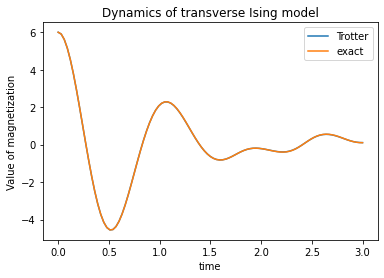

In [6]:
plt.xlabel("time")
plt.ylabel("Value of magnetization")
plt.title("Dynamics of transverse Ising model")
plt.plot(x, y_trotter, "-", label="Trotter")
plt.plot(x, y_exact, "-", label="exact")
plt.legend()
plt.show()

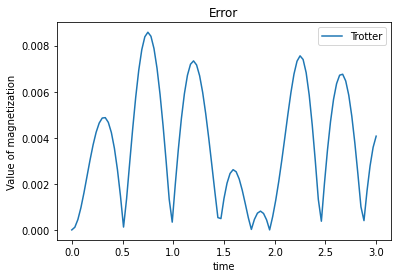

In [7]:
plt.xlabel("time")
plt.ylabel("Value of magnetization")
plt.title("Error")
plt.plot(x, np.abs(np.array(y_trotter) - np.array(y_exact)), "-", label="Trotter")
plt.legend()
plt.show()